# Hotel Recognition to Combat Human Trafficking | Train
    2021-05-09
    Edward Sims




## 1.00 Import Packages

In [25]:
# General packages
import pandas as pd
import numpy as np
import os
import gc
import random
from tqdm import tqdm, tqdm_notebook
import cv2
from datetime import datetime as dt
import pickle

import time
import warnings
import multiprocessing

# Data vis packages
import matplotlib.pyplot as plt
%matplotlib inline

# Modelling packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as k
# Key layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Add, Dense, Flatten
# Activation layers
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU, ThresholdedReLU
# Dropout layers
from tensorflow.keras.layers import Dropout, AlphaDropout, GaussianDropout
# Normalisation layers
from tensorflow.keras.layers import BatchNormalization
# Embedding layers
from tensorflow.keras.layers import Embedding, Concatenate, Reshape
# Callbacks
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint
# Optimisers
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
# Model cross validation and evaluation
from sklearn.model_selection import KFold
from tensorflow.keras.losses import sparse_categorical_crossentropy

# For Bayesian hyperparameter searching
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

# Package options
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 50)
plt.rcParams["figure.figsize"] = [14, 8]

In [26]:
# Check GPU config
print(f"Number of GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

strategy = tf.distribute.get_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# Data access
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

# Get number of cpu cores for multiprocessing
try:
    cpus = int(multiprocessing.cpu_count() / 2)
except NotImplementedError:
    cpus = 1 # Default number of cores
    
print(f"Number of CPU Cores: {cpus}")

# Disable eager execution for mAP metric
#tf.compat.v1.disable_eager_execution()

Number of GPUs Available: 1
REPLICAS: 1
Number of CPU Cores: 64


## 2.00 Data Preparation
### 2.01 Read in Data

In [27]:
# Data paths
data_dir_path         = "../input/hotel-id-2021-fgvc8"
train_images_dir_path = os.path.join(data_dir_path, "train_images")
test_images_dir_path  = os.path.join(data_dir_path, "test_images")

train_metadata_path   = os.path.join(data_dir_path, "train.csv")
sample_sub_path       = os.path.join(data_dir_path, "sample_submission.csv")

# Read csv data
train_metadata        = pd.read_csv(train_metadata_path, parse_dates=["timestamp"])
sample_sub            = pd.read_csv(sample_sub_path)

# Remove 2 duplicated records from metadata
train_metadata_dupes = train_metadata.loc[train_metadata.groupby("image")["image"].transform("count") > 1, ]
train_metadata_dupes_idx = train_metadata_dupes.iloc[[1, 3]].index
train_metadata = train_metadata.drop(train_metadata_dupes_idx, axis=0)

train_metadata = train_metadata.sort_values("hotel_id")

### 2.02 Set default parameters

In [28]:
# Define key parameters
SEED = 14
np.random.seed(SEED)

ROWS     = 128 # Default row size
COLS     = 128 # Default col size
CHANNELS = 3

EPOCHS     = 100
BATCH_SIZE = 64
PATIENCE   = 10

# Read all images in and subset in CV? Or Read images inside each fold in CV?
read_images_in_fold = True
# Treat model as baseline or not
is_baseline = True

# Uncomment as appropriate
#MODEL_TO_USE = "densenet121"
#MODEL_TO_USE = "densenet169"
#MODEL_TO_USE = "densenet201"
#MODEL_TO_USE = "efficientnet_b0"
#MODEL_TO_USE = "efficientnet_b1"
#MODEL_TO_USE = "efficientnet_b2"
#MODEL_TO_USE = "efficientnet_b3"
#MODEL_TO_USE = "efficientnet_b4"
#MODEL_TO_USE = "efficientnet_b5"
#MODEL_TO_USE = "inception_resnetv2"
#MODEL_TO_USE = "inceptionv3"
#MODEL_TO_USE = "resnet50v2"
#MODEL_TO_USE = "resnet101v2"
#MODEL_TO_USE = "resnext50"
#MODEL_TO_USE = "resnext101"
#MODEL_TO_USE = "resnet152v2"
#MODEL_TO_USE = "vgg19"
MODEL_TO_USE = "xception"

kfold_params = {
    0: {"ROWS": ROWS,"COLS": COLS},
    1: {"ROWS": ROWS,"COLS": COLS},
    2: {"ROWS": ROWS,"COLS": COLS},
    #3: {"ROWS": ROWS,"COLS": COLS},
    #4: {"ROWS": ROWS,"COLS": COLS},
    #5: {"ROWS": ROWS,"COLS": COLS},
    #6: {"ROWS": ROWS,"COLS": COLS},
    #7: {"ROWS": ROWS,"COLS": COLS}
}

KFOLDS = len(kfold_params)

if is_baseline == True:
    model_name_save = f"baseline_{MODEL_TO_USE}_{str(ROWS)}x{str(COLS)}_{str(KFOLDS)}folds_seed{str(SEED)}"
elif is_baseline == False:
    model_name_save = f"{MODEL_TO_USE}_{str(ROWS)}x{str(COLS)}_{str(KFOLDS)}folds_seed{str(SEED)}"

# Create models path if does not exist already
if not os.path.exists(f"models/{model_name_save}"):
    os.mkdir(f"models/{model_name_save}")

print(f"Model name: {model_name_save}")

Model name: baseline_xception_128x128_3folds_seed14


In [29]:
# Metadata preparation
def get_is_weekend(timestamp_col):
    """
    Returns boolean for whether timestamp is a weekend.
    """
    timestamp_col_weekday = timestamp_col.dt.weekday
    # Allocate booleans - Weekends are designated 6 & 7
    timestamp_col_weekday = timestamp_col_weekday.apply(lambda x: False if x < 5 else True)
    
    return timestamp_col_weekday

# Extract year, month and hour from timestamp feature
train_metadata["year"] = train_metadata["timestamp"].dt.year
train_metadata["month"] = train_metadata["timestamp"].dt.month
train_metadata["hour"] = train_metadata["timestamp"].dt.hour
# Extract is_weekend from timestamp
train_metadata["is_weekend"] = get_is_weekend(train_metadata["timestamp"])
train_metadata = train_metadata.drop("timestamp", axis=1)

# Extract labels from metadata
y_train_vector = np.array(train_metadata["hotel_id"])
y_train = np.zeros((y_train_vector.size, y_train_vector.max() + 1))
y_train[np.arange(y_train_vector.size), y_train_vector] = 1

num_classes = len(np.unique(y_train_vector))

### 2.03 Read Images

In [31]:
def get_image_paths(image_dir_path):
    """Reads images into np.array from directory of image files.

    Parameters
    ----------
    image_dir : list
        Directory of images to read from.

    Returns
    -------
    list
        List of images paths to.

    """
    # Get list of all image paths
    image_path_list = []
    try:
        for chain_id in os.listdir(image_dir_path):
            # Each subdirectory is a chain_id
            chain_id_dir_path = os.path.join(image_dir_path, chain_id)
            # Read images from each chain_id subdirectory
            for image in os.listdir(chain_id_dir_path): 
                # Read image
                image_path = os.path.join(chain_id_dir_path, image)
                # Append to list of images
                image_path_list.append(image_path)
    except NotADirectoryError:
        # Read images from each chain_id subdirectory
        for image in os.listdir(image_dir_path): 
            # Read image
            image_path = os.path.join(image_dir_path, image)
            # Append to list of images
            image_path_list.append(image_path)

    # Remove all non-jpg files
    for idx, path in enumerate(image_path_list):
        if ".jpg" not in path and ".png" not in path:
            del image_path_list[idx]
    
    return image_path_list


def load_image(image_path):
    """
    Read and return single resized image.
    """
    try:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    except:
        pass

    
def read_images(images_paths):
    # Read in train and test images asynchrously
    pool = multiprocessing.Pool(processes=cpus)
    images_array = np.array(pool.map(load_image, images_paths))
    pool.close()
    pool.join()
    
    return images_array

In [32]:
# Get all full image paths
train_images_path_list = get_image_paths(train_images_dir_path)
test_images_path_list = get_image_paths(test_images_dir_path)

### 2.04 Image Augmentations

In [33]:
def preprocess_imgs(train_imgs, test_imgs, verbose=0):
    """Centers images by minusing the mean and dividing by std
    
    Parameters
    ----------
    train_imgs : array 
        Train images to read in and normalise
    test_imgs : array
        Test images to read in and normalise
        
    Returns
    -------
    np.array
        2 np.arrays including original images and augmented images (for train and test set).
    """
    
    if verbose == 1:
        print("Preprocessing images...\n")
    # Convert pixel values to float
    train_imgs = train_imgs.astype(float)
    test_imgs = test_imgs.astype(float)

    # Get per-channel means and stds    
    train_means = train_imgs.reshape(-1, train_imgs.shape[-1]).mean(axis=0)
    train_stds = train_imgs.reshape(-1, train_imgs.shape[-1]).std(axis=0)

    # Standardise images
    train_imgs -= train_means
    train_imgs /= train_stds
    
    test_imgs -= train_means
    test_imgs /= train_stds
    
    if verbose == 1:
        print(f"Train per-channel means: {train_imgs.reshape(-1, train_imgs.shape[-1]).mean(axis=0)}")
        print(f"Trin per-channel stds: {train_imgs.reshape(-1, train_imgs.shape[-1]).std(axis=0)}")

    return train_imgs, test_imgs

In [34]:
def make_train_augmentations(train_imgs, y, p, aug, verbose=0):
    """Make a random subset of p proportion. Apply augmentations
        to the subset and append back to the original dataset, 
        making necessary changes to labels.
    
    Parameters
    ----------
    train_imgs : array
        Train images to read in and augment
    y : array
        Train labels to copy as per augmented images
    p : float
        sample size probability
    aug : string
        Choice of augmentation from ['fliplr', 'rot90', 'rot180']
        
    Returns
    -------
    np.array
        np.array of original images and augmented images and their corresponding labels.
    """
    
    if verbose == 1:
        print('Augmenting images...')
    # Get a sample of X and y based on p proportion
    sample_size = int(round(len(y) * p))
    idx_sample = random.sample(range(0, len(y), 1), sample_size)

    # Make augmentations to sample
    if aug == "fliplr":
        train_imgs = np.concatenate(
            (train_imgs, np.array([np.fliplr(train_imgs[i]) for i in idx_sample])),
            axis=0
        )
    elif aug == "rot90":
        train_imgs = np.concatenate(
            (train_imgs, np.array([np.rot90(train_imgs[i], 1) for i in idx_sample])),
            axis=0
        )
    elif aug == "rot180":
        train_imgs = np.concatenate(
            (train_imgs, np.array([np.rot90(train_imgs[i], 2) for i in idx_sample])),
            axis=0
        )
    
    elif aug == "rot270":
        train_imgs = np.concatenate(
            (train_imgs, np.array([np.rot90(train_imgs[i], 3) for i in idx_sample])),
            axis=0
        )

    
    # Copy labels accordingly
    y_sample = np.array([y[i] for i in idx_sample])
    y = np.concatenate((y, y_sample), axis=0)

    return train_imgs, y

In [35]:
if read_images_in_fold == False:
    train_images = read_images(train_images_path_list)
    test_images  = read_images(test_images_path_list)
    print(f"Train images shape: {train_images.shape}")
    print(f"Test images shape:  {test_images.shape}")    

## 3.00 Modelling
### 3.01 Learning Rate

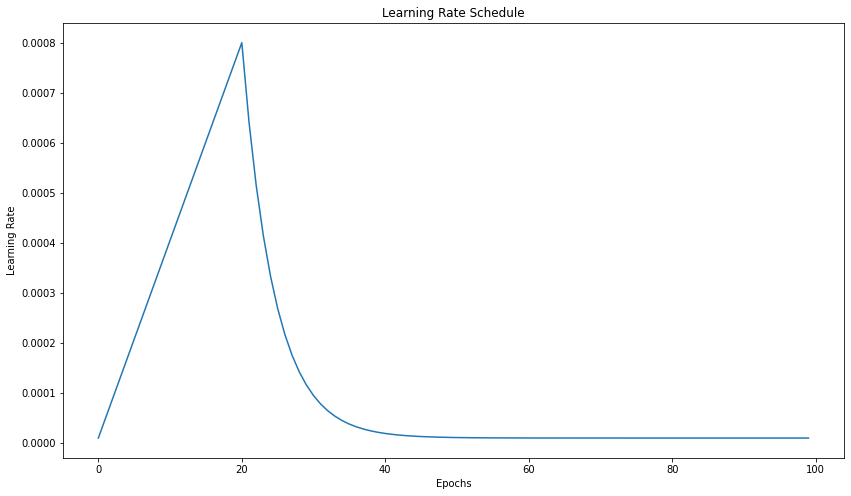

In [36]:
def build_lrfn(lr_start          = 0.00001, 
               lr_max            = 0.0008, 
               lr_min            = 0.00001, 
               lr_rampup_epochs  = 20, 
               lr_sustain_epochs = 0, 
               lr_exp_decay      = 0.8):
    
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr

    return lrfn

lrfn = build_lrfn()
lr = LearningRateScheduler(lrfn, verbose=0)

plt.plot([lrfn(epoch) for epoch in range(EPOCHS)])
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()

### 3.02 Compiler Metrics

In [37]:
# Define Mean Average Precision at K metric
map_at_k = tf.compat.v1.metrics.average_precision_at_k

In [38]:
#y_true = np.array([[4], [4], [4], [4], [4]]).astype(np.int64)
#y_true = tf.identity(y_true)
#
#y_pred = np.array([[0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.1, 0.2, 0.6],
#                   [0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.1, 0.2, 0.6],
#                   [0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.1, 0.2, 0.6],
#                   [0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.1, 0.2, 0.6],
#                   [0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.1, 0.2, 0.6]
#                   ]).astype(np.float32)
#y_pred = tf.identity(y_pred)
#
#_, m_ap = map_at_k(y_true, y_pred, 5)
#
#sess = tf.Session()
#sess.run(tf.local_variables_initializer())
#
#stream_vars = [i for i in tf.local_variables()]
#
#tf_map = sess.run(m_ap)
#print(tf_map)
#
#tmp_rank = tf.nn.top_k(y_pred, 5)
#
#print(sess.run(tmp_rank))

### 3.03 CNN Models

In [39]:
# The model we'll feed the images into before concatenation
def get_cnn_model(kfold, model_to_use=MODEL_TO_USE, verbose=1):
    """Get the pretrained CNN model specified.
    
    Parameters
    ----------
    kfold : int 
        Fold that the CV is currently on (to determine img size)
    model_to_use : str 
        Model to retrieve
    verbose : int
        Level of output communication. 0=None, 1=All.
        
    Returns
    -------
    model_return : 
    """
    if verbose == 1:
        print("\nLoading pretrained model...")
                        
    input_shape = (
        kfold_params[kfold]["ROWS"],
        kfold_params[kfold]["COLS"],
        CHANNELS
    )
    
    # DenseNet121
    if model_to_use == "densenet121":
        from tensorflow.keras.applications import DenseNet121
        model_return = DenseNet121(input_shape=input_shape, include_top=False)
        
    # DenseNet169
    elif model_to_use == "densenet169":
        from tensorflow.keras.applications import DenseNet169
        model_return = DenseNet169(input_shape=input_shape, include_top=False)
        
    # DenseNet201
    elif model_to_use == "densenet201":
        from tensorflow.keras.applications import DenseNet201
        model_return = DenseNet201(input_shape=input_shape, include_top=False)
            
    # EfficientNet_B0
    elif model_to_use == "efficientnet_b0":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB0(
            input_shape=input_shape, include_top=False
        )
    
    # EfficientNet_B1
    elif model_to_use == "efficientnet_b1":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB1(
            input_shape=input_shape, include_top=False
        )
            
    # EfficientNet_B2
    elif model_to_use == "efficientnet_b2":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB2(
            input_shape=input_shape, include_top=False
        )
            
    # EfficientNet_B3
    elif model_to_use == "efficientnet_b3":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB3(
            input_shape=input_shape, include_top=False
        )
            
    # EfficientNet_B4
    elif model_to_use == "efficientnet_b4":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB4(
            input_shape=input_shape, include_top=False
        )
            
    # EfficientNet_B5
    elif model_to_use == "efficientnet_b5":
        import efficientnet.tfkeras as efficientnet
        model_return = efficientnet.EfficientNetB5(
            input_shape=input_shape, include_top=False
        )

    # InceptionResNetV2
    elif model_to_use == "inception_resnetv2":
        from tensorflow.keras.applications import InceptionResNetV2
        model_return = InceptionResNetV2(input_shape=input_shape, include_top=False)

    # InceptionV3
    elif model_to_use == "inceptionv3":
        from tensorflow.keras.applications import InceptionV3
        model_return = InceptionV3(input_shape=input_shape, include_top=False)
    
    # NasNetLarge
    elif model_to_use == "nasnetlarge":
        from tensorflow.keras.applications import NASNetLarge
        model_return = NASNetLarge(input_shape=input_shape, include_top=False)
        
    # ResNet50V2
    elif model_to_use == "resnet50v2":
        from tensorflow.keras.applications import ResNet50V2
        model_return = ResNet50V2(input_shape=input_shape, include_top=False)

    # ResNet101V2
    elif model_to_use == "resnet101v2":
        from tensorflow.keras.applications import ResNet101V2
        model_return = ResNet101V2(input_shape=input_shape, include_top=False)

    # ResNet152V2
    elif model_to_use == "resnet152v2":
        from tensorflow.keras.applications import ResNet152V2
        model_return = ResNet152V2(input_shape=input_shape, include_top=False)

    # ResNeXt50
    elif model_to_use == "resnext50":
        from keras_applications.resnext import ResNeXt50
        model_return = ResNeXt50(
            input_shape=input_shape, 
            include_top=False, 
            classes=classes,
            backend=keras.backend, 
            layers=keras.layers, 
            models=keras.models, 
            utils=keras.utils
        )

    # ResNeXt101
    elif model_to_use == "resnext101":
        from keras_applications.resnext import ResNeXt101
        model_return = ResNeXt101(
            input_shape=input_shape, 
            include_top=False, 
            classes=classes,
            backend=keras.backend, 
            layers=keras.layers, 
            models=keras.models, 
            utils=keras.utils
        )
        
    # VGG19
    elif model_to_use == "vgg19":
        from tensorflow.keras.applications import VGG19
        model_return = VGG19(input_shape=input_shape, include_top=False)

    # Xception
    elif model_to_use == "xception":
        from tensorflow.keras.applications import Xception
        model_return = Xception(input_shape=input_shape, include_top=False)
        
    return model_return

### 3.04 Stratified Group Cross Validation

In [40]:
def stratified_group_k_fold(X, y, groups, k, seed=SEED):
    """https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation"""
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

### 3.05 Train Model

In [48]:
class DataGenerator(keras.utils.Sequence):
    """
    Generates data for Keras
    """
    def __init__(self, list_IDs, labels, batch_size=BATCH_SIZE, dim=(len(y_train), ROWS, COLS), 
                 n_channels=CHANNELS, n_classes=num_classes, shuffle=True):
        "Initialization"
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

        
    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    
    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indexes of the batch
        indexes = self.indexes[index *self.batch_size: (index + 1) *self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    
    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def __data_generation(self, list_IDs_temp):
        """
        Generates data containing batch_size samples
        """ 
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load(f"data/{ID}.npy")
            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
def get_in_fold_data(kfold, tdx, vdx, read_images_in_fold=read_images_in_fold):
    """
    
    Parameters
    ----------
    kfold : int
        the current fold in CV
    tdx : list
        train indices for the current fold
    vdx : list
        validation indices for the current fold
    read_images_in_fold : bool 
        whether to read the images inside or outside of folds
    loading_bar : bool
        include a loading bar when loading CV images
    """
    
    print('Fetching data...')
    
    # Get image paths
    X_path, X_path_val, = np.array(train_images_path_list)[tdx], np.array(train_images_path_list)[vdx]
    # Get values for target
    y, y_val = y_train[tdx], y_train[vdx]        
    
    if read_images_in_fold == False:
        # Get values for imgs
        X_img = np.array(
            [cv2.resize(
                img, 
                (kfold_params[kfold]["ROWS"], # Row size for current fold
                 kfold_params[kfold]["COLS"]) # Col size for current fold
            ) for img in train_images[tdx]]
        )
        X_img_val = np.array(
            [cv2.resize(
                img, 
                (kfold_params[kfold]["ROWS"], # Row size for current fold
                 kfold_params[kfold]["COLS"]) # Col size for current fold
            ) for img in train_images[vdx]]
        )
            
    elif read_images_in_fold == True:
        # Read images in from scratch
        X_img = np.array(
            [cv2.resize(
                img, 
                (kfold_params[kfold]["ROWS"], # Row size for current fold
                 kfold_params[kfold]["COLS"]) # Col size for current fold
            ) for img in read_images(X_path)]
        )
        
        X_img_val = np.array(
            [cv2.resize(
                img, 
                (kfold_params[kfold]["ROWS"], # Row size for current fold
                 kfold_params[kfold]["COLS"]) # Col size for current fold
            ) for img in read_images(X_path_val)]
        )
    
    return X_img, X_img_val, y, y_val

In [ ]:
def make_test_augmentations(img):
    """
    Returns augmented image(s) and original.
    """
    img_augs = np.concatenate(
        (
            np.expand_dims(img, axis=0),
            np.expand_dims(np.rot90(img, 1), axis=0),
            np.expand_dims(np.rot90(img, 2), axis=0),
            np.expand_dims(np.rot90(img, 3), axis=0),
            np.expand_dims(np.fliplr(img), axis=0),
            np.expand_dims(np.fliplr(np.rot90(img, 1)), axis=0),
            np.expand_dims(np.fliplr(np.rot90(img, 2)), axis=0),
            np.expand_dims(np.fliplr(np.rot90(img, 3)), axis=0)),
        axis=0
    )
        
    return(img_augs)

### 3.06 Define and Train Baseline Model

In [ ]:
def get_baseline_model(kfold, model_cnn=MODEL_TO_USE, verbose=1):
    model_cnn = get_cnn_model(kfold, model_cnn)
    # Add a global spatial average pooling layer
    x = model_cnn.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    # Define output layer
    output = Dense(y_train.shape[1], activation="softmax")(x)
    # Define final model
    model = Model(inputs=model_cnn.input, outputs=output)
    
    return model

In [ ]:
if is_baseline == True:
    # Define CV strategy
    kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=SEED)
    loss_scores = []
    best_params = pd.DataFrame(columns=["kfold", "seed"])

    for fold, (tdx, vdx) in enumerate(kf.split(train_images_path_list[0:500], y_train[0:500])):
        print(f"FOLD {fold}")
        print("--------------------------------------------------------------------------------------------")
        # Create name to save model by
        model_save_path = f"models/{model_name_save}/{model_name_save}_{str(fold)}.h5"
        model_save_path_temp = f"models/{model_name_save}/TEMP_{model_name_save}_{str(fold)}.h5"
        
        
        
        
        # Parameters
        params = {
            "dim": (len(y_train), ROWS, COLS),
            "batch_size": BATCH_SIZE,
            "n_classes": num_classes,
            "n_channels": CHANNELS,
            "shuffle": True
        }

        # Datasets
        partition = #
        #labels = # Labels
        #
        ## Generators
        #training_generator = DataGenerator(partition["train"], labels, **params)
        #validation_generator = DataGenerator(partition["validation"], labels, **params)

        # Design model
        #model = Sequential()
        #[...] # Architecture
        #model.compile()
        #
        ## Train model on dataset
        #model.fit_generator(generator=training_generator,
        #                    validation_data=validation_generator,
        #                    use_multiprocessing=True,
        #                    workers=6)
        
        
        
        
        
        
        # Fetch in-fold data
        #X_tdx, X_vdx, y_tdx, y_vdx = get_in_fold_data(fold, tdx, vdx)
        #
        # Get baseline model
        #model = get_baseline_model(fold)
        #
        ## Compile model
        #model.compile(optimizer="adam", loss="categorical_crossentropy")
    #
        ## Define learning rate schedule
        #lr = LearningRateScheduler(lrfn, verbose=0)
        #
        ## Define early stopping parameters
        #es = EarlyStopping(
        #    monitor="val_loss", 
        #    mode="min",
        #    restore_best_weights=True, 
        #    verbose=0, 
        #    patience=PATIENCE
        #)
        #
        ## Define model checkpoint parameters
        #mc = ModelCheckpoint(
        #    filepath=model_save_path_temp, 
        #    save_best_only=True, 
        #    save_weights_only=False,
        #    monitor="val_loss", 
        #    mode="min",
        #    verbose=0
        #)
    #
        # Fit model
        #print("TRAINING...")
        #history = model.fit(
        #    X_tdx, y_tdx,
        #    epochs=EPOCHS,
        #    batch_size=BATCH_SIZE,
        #    callbacks = [es, lr, mc],
        #    verbose=0,
        #    validation_split=0.25
        #)
        #    
        ## Get val_loss for the best model (one saved with ModelCheckpoint)
        #loss = min(history.history["val_loss"])
        #print(f"CURRENT LOSS: \t\t{loss}")
        
        #    # If the classification loss of the saved model is improved
        #    if loss < best_loss:
        #        model.save(model_save_name)
        #        best_loss = loss
        #        
        #        # Save transformed validation arrays (so they can be used for prediction)
        #        global X_vdx_best_model, y_vdx_best_model
        #        X_vdx_best_model, y_vdx_best_model = X_vdx, y_vdx
        #        
        #        ### SAVE MODEL PARAMETERS ### 
        #        best_params = best_params.loc[best_params.kfold != fold]
        #        best_params = best_params.append({'kfold'            : fold,
        #                                          'selected_features': selected_features,
        #                                          'num_features'     : NUM_FEATURES,
        #                                          'num_components'   : NUM_COMPONENTS,
        #                                          'use_embedding'    : USE_EMBEDDING,
        #                                          'seed'             : SEED}, 
        #                                         ignore_index=True)
        #        best_params.to_csv('final_classifier_parameters/' + model_name_save + '.csv', index=False)
        #        
        #    print(f'BEST LOSS: \t\t{best_loss}\n')
    #
        #    del model
        #    k.clear_session()
        #    return(loss)
        #
        ### RUN BAYESIAN HYPERPARAMETER SEARCH ##
        #print('RUNNING PARAMETER SEARCH...\n')
        #time.sleep(2)
        #best_loss = np.Inf
        #search_iteration = 1
        #
        #gp_result = gp_minimize(func         = get_hyperopts,
        #                        dimensions   = dimensions,
        #                        acq_func     = 'EI', # Expected Improvement.
        #                        n_calls      = 50,
        #                        noise        = 0.01,
        #                        n_jobs       = -1,
        #                        kappa        = 5,
        #                        x0           = default_parameters,
        #                        random_state = SEED
        #                       )
        #
        #
        #print('\nSEARCH COMPLETE.')
        #print('MAKING VALIDATION PREDICTIONS...')
        #
        ## Load best model
        #model = load_model(model_save_name)
        ## Make validation predictions
        #preds = model.predict(X_vdx_best_model)
        #
        ## Calculate OOF loss 
        #oof_loss = metric(np.array(y_vdx_best_model), np.array(preds))
    #
        #print('FOLD ' + str(fold) + ' LOSS: ' + str(oof_loss))
        #print('--------------------------------------------------------------------------------------------')
        #time.sleep(2)
        #loss_scores.append(oof_loss)
    #
        ## Clean up
        #gc.collect()
        #os.remove(model_save_name_temp)

### 3.07 Bayesian Hyperparameter Search

In [ ]:
# Define hyperparameter search dimensions
dim_learning_rate    = Real(low=1e-4,   high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=1,   high=6,    name='num_dense_layers')
dim_num_input_nodes  = Integer(low=1,   high=4096, name='num_input_nodes')
dim_num_dense_nodes  = Integer(low=1,   high=4096, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu','leaky_relu','elu','threshold_relu'], name='activation')
dim_batch_size       = Integer(low=1,   high=64,   name='batch_size')
dim_patience         = Integer(low=3,   high=15,   name='patience')
dim_optimiser = Categorical(
    categories=['sgd','adam','rms_prop','ada_delta','ada_grad', 'ada_max','n_adam','ftrl'], name='optimiser'
)
dim_optimiser_decay  = Real(low=1e-6,   high=1e-2, name='optimiser_decay')
dim_dropout_layer = Categorical(categories=['dropout','gaussian_dropout','alpha_dropout'],name='dropout_layer')
dim_dropout_val      = Real(low=0.1,    high=0.8,  name='dropout_val')

dimensions = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_input_nodes,
    dim_num_dense_nodes,
    dim_activation,
    dim_batch_size,
    dim_patience,
    dim_optimiser,
    dim_optimiser_decay,
    dim_dropout_layer,
    dim_dropout_val,
]

# Set default hyperparameters
default_parameters = [
    1e-3,      # learning_rate
    1,         # num_dense_layers
    512,       # num_input_nodes
    16,        # num_dense_nodes
    'relu',    # activation
    64,        # batch_size
    3,         # patience
    'adam',    # optimiser
    1e-3,      # optimiser_decay
    'dropout', # dropout_layer
    0.1,       # dropout_val
]

### 3.08 Train Model with Bayesian Hyperparameter Search

In [ ]:
# Define CV strategy
kf = KFold(n_splits=KFOLDS, random_state=SEED)
loss_scores = []
best_params = pd.DataFrame(columns=['kfold','selected_features','num_features',
                                    'num_components','use_embedding','seed'])

for fold, (tdx, vdx) in enumerate(kf.split(X, y)):
    print(f'FOLD {fold}')
    print('--------------------------------------------------------------------------------------------------')
    # Create name to save model by
    model_save_name = 'models/' + model_name_save + '/' + model_name_save + '_' + str(fold) + '.h5'
    model_save_name_temp = 'models/' + model_name_save + '/' + 'TEMP_'+ model_name_save+ '_' + str(fold) + '.h5'
    
    @use_named_args(dimensions=dimensions)
    def get_hyperopts(learning_rate, 
                      num_dense_layers, 
                      num_input_nodes, 
                      num_dense_nodes,
                      activation, 
                      batch_size,
                      patience,
                      optimiser,
                      optimiser_decay,
                      dropout_layer,
                      dropout_val):

        # Define key parameters - these are affected by parameter search so must be done inside function
        BATCH_SIZE = batch_size
        PATIENCE   = patience

        
        # Fetch in-fold data
        X_tdx, X_vdx, y_tdx, y_vdx = X.iloc[tdx, :], X.iloc[vdx, :], y.iloc[tdx, :], y.iloc[vdx, :]

        # Define activation layers
        if activation == 'relu':
            ACTIVATION = ReLU()
        elif activation == 'leaky_relu':
            ACTIVATION = LeakyReLU()
        elif activation == 'elu':
            ACTIVATION = ELU()
        elif activation == 'threshold_relu':
            ACTIVATION = ThresholdedReLU()

        # Define regularisation layers
        if dropout_layer == 'dropout':
            REG_LAYER = Dropout(dropout_val)
        elif dropout_layer == 'gaussian_dropout':
            REG_LAYER = GaussianDropout(dropout_val)
        elif dropout_layer == 'alpha_dropout':
            REG_LAYER = AlphaDropout(dropout_val)

        # Define optimisers #
        if optimiser == 'sgd':
            OPTIMISER = SGD(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'adam':
            OPTIMISER = RMSprop(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'rms_prop':
            OPTIMISER = Adam(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ada_delta':
            OPTIMISER = Adadelta(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ada_grad':
            OPTIMISER = Adagrad(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ada_max':
            OPTIMISER = Adamax(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'n_adam':
            OPTIMISER = Nadam(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ftrl':
            OPTIMISER = Ftrl(lr=learning_rate, decay=optimiser_decay)

        ## BUILD MODEL BASED ON INPUTTED BAYESIAN HYPERPARAMETERS ##
        # Input layer #
        if USE_EMBEDDING == 1:
            inputs = []
            embeddings = []
            for col in cat_cols:
                # Create categorical embedding for each categorical feature
                input_ = Input(shape=(1,))
                input_dim = int(X_tdx[col].max() + 1)
                embedding = Embedding(input_dim=input_dim, output_dim=10, input_length=1)(input_)
                embedding = Reshape(target_shape=(10,))(embedding)
                inputs.append(input_)
                embeddings.append(embedding)
            input_numeric = Input(shape=(len(num_cols),))
            embedding_numeric = Dense(num_input_nodes)(input_numeric) 
            embedding_numeric = ACTIVATION(embedding_numeric) 
            inputs.append(input_numeric)
            embeddings.append(embedding_numeric)
            x = Concatenate()(embeddings)
        if USE_EMBEDDING == 0:
            input_ = Input(shape=(X_tdx.shape[1], ))
            x = Dense(num_input_nodes)(input_)
        # Hidden layers #
        for i in range(num_dense_layers):
            layer_name = f'layer_dense_{i+1}'
            x = Dense(num_dense_nodes, name=layer_name)(x)
            x = ACTIVATION(x)
            x = BatchNormalization()(x)
            x = REG_LAYER(x) 
        # Output layer #
        output = Dense(y.shape[1], activation='softmax')(x)

        if USE_EMBEDDING == 1:
            model = Model(inputs, output)
        elif USE_EMBEDDING == 0:
            model = Model(input_, output)

        
        # COMPILE MODEL #
        model.compile(optimizer=OPTIMISER, 
                      loss='binary_crossentropy')

        # Define learning rate schedule
        lr = LearningRateScheduler(lrfn, verbose=0)
        
        # Define early stopping parameters
        es = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           restore_best_weights=True, 
                           verbose=0, 
                           patience=PATIENCE)
        
        # Define model checkpoint parameters
        mc = ModelCheckpoint(filepath=model_save_name_temp, 
                             save_best_only=True, 
                             save_weights_only=False,
                             monitor='val_loss', 
                             mode='min',
                             verbose=0)

        if USE_EMBEDDING == 1:
            # Separate data to fit into embedding and numerical input layers
            X_tdx = [np.absolute(X_tdx[i]) for i in cat_cols] + [X_tdx[num_cols]]
            X_vdx = [np.absolute(X_vdx[i]) for i in cat_cols] + [X_vdx[num_cols]]

        # FIT MODEL #
        print('TRAINING...')
        history = model.fit(X_tdx, y_tdx,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            callbacks = [es, lr, mc],
                            verbose=0,
                            validation_split=0.25
                           )
        
        # Get val_loss for the best model (one saved with ModelCheckpoint)
        loss = min(history.history['val_loss'])
        print(f'CURRENT LOSS: \t\t{loss}')
        
        # Save best loss and parameters to global memory
        global best_loss
        global best_params

        # If the classification loss of the saved model is improved
        if loss < best_loss:
            model.save(model_save_name)
            best_loss = loss
            
            # Save transformed validation arrays (so they can be used for prediction)
            global X_vdx_best_model, y_vdx_best_model
            X_vdx_best_model, y_vdx_best_model = X_vdx, y_vdx
            
            ### SAVE MODEL PARAMETERS ### 
            best_params = best_params.loc[best_params.kfold != fold]
            best_params = best_params.append({'kfold'            : fold,
                                              'selected_features': selected_features,
                                              'num_features'     : NUM_FEATURES,
                                              'num_components'   : NUM_COMPONENTS,
                                              'use_embedding'    : USE_EMBEDDING,
                                              'seed'             : SEED}, 
                                             ignore_index=True)
            best_params.to_csv('final_classifier_parameters/' + model_name_save + '.csv', index=False)
            
        print(f'BEST LOSS: \t\t{best_loss}\n')

        del model
        k.clear_session()
        return(loss)
    
    ## RUN BAYESIAN HYPERPARAMETER SEARCH ##
    print('RUNNING PARAMETER SEARCH...\n')
    time.sleep(2)
    best_loss = np.Inf
    search_iteration = 1
    
    gp_result = gp_minimize(func         = get_hyperopts,
                            dimensions   = dimensions,
                            acq_func     = 'EI', # Expected Improvement.
                            n_calls      = 50,
                            noise        = 0.01,
                            n_jobs       = -1,
                            kappa        = 5,
                            x0           = default_parameters,
                            random_state = SEED
                           )
    
    
    print('\nSEARCH COMPLETE.')
    print('MAKING VALIDATION PREDICTIONS...')
    
    # Load best model
    model = load_model(model_save_name)
    # Make validation predictions
    preds = model.predict(X_vdx_best_model)
    
    # Calculate OOF loss 
    oof_loss = metric(np.array(y_vdx_best_model), np.array(preds))

    print('FOLD ' + str(fold) + ' LOSS: ' + str(oof_loss))
    print('--------------------------------------------------------------------------------------------------')
    time.sleep(2)
    loss_scores.append(oof_loss)

    # Clean up
    gc.collect()
    os.remove(model_save_name_temp)